# Estimating a Yield Curve Model

## Load Packages and Extra Functions

In [1]:
using Printf, Dates, DelimitedFiles, Statistics, LinearAlgebra, Optim

include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots

#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

## Loading Data

Some of the interest rates need to be converted from discount basis to effective rates by using the function `disc2eff()`.

In [3]:
disc2eff(y,m) = ( (1.0.-m*y/100).^(-1/m) .- 1 )*100    #discount basis->effective rate

disc2eff (generic function with 1 method)

In [4]:
x   = readdlm("Data/USCMRatesPs.csv",',',skipstart=1)
y   = convert.(Float64,x[:,3:end])         #interest rates, 3m to 10y, skip FFR
ymd = x[:,1]                               #strings, "2012-03-01"

dN = Date.(ymd,"yyyy-mm-dd")               #Julia dates 

y[:,1] = disc2eff(y[:,1],0.25)
y[:,2] = disc2eff(y[:,2],0.5)

m      = [0.25 0.5 1 3 5 7 10]      #time to maturity (in years)
mMonth = round.(Int,m*12)           #maturities, in months (integers)
y      = log.(1.0.+y/100)           #continuously compounded interest rates
y      = y/12                       #interest rates per month (the period length of data)

(T,n) = size(y)

(570, 7)

## Establishing Notation for an Affine Yield Curve Model


An affine yield curve model implies that the yield on an $n$-period discount
bond is

$
y_{nt}=a_{n}+b_{n}^{\prime}x_{t}
$

where $x_{t}$ is an $K\times1$ vector of state variables. Here $a_{n}$ is a
scalar and $b_{n}$ is a $K\times1$ vector (so $b_{n}^{\prime}x_{t}$ is a scalar). 

Transpose to get

$
y_{nt}=a_{n}+x_{t}^{\prime}b_{n}
$

As an example, consider two different maturities ($n$), denoted $1$ and $2$.
The row vector is then

$
\begin{bmatrix} 
y_{1t} & y_{2t} 
\end{bmatrix} =
\begin{bmatrix} 
a_{1} & a_{2} 
\end{bmatrix}
+x_{t}^{\prime} 
\begin{bmatrix} b_{1} & b_{2} 
\end{bmatrix}.
$

### From Model Parameters to $a_{n}$ and $b_{n}$

The following function VasicekABFn.jl takes the
Vasicek model parameters as inputs and calculates the $a_{n}$ and $b_{n}$ values.

In [5]:
function VasicekABFn(lambda,mu,rho,sigma,nMo,nMu,yo)

  nMax = maximum([nMo;nMu])    #longest maturity to calculate (a,b) for
  Nvec = 1:nMax

  (A,B) = [fill(NaN,(1,nMax)) for i=1:2]        #recursive solution of AR(1) model
  B[1] = 1
  A[1] = -(lambda+0)^2*sigma^2/2
  for n = 2:nMax
    B[n] = 1 + B[n-1]*rho
    A[n] = A[n-1] + B[n-1]*(1-rho)*mu - (lambda+B[n-1])^2*sigma^2/2
  end

  a  = A./Nvec'                          #1xnMax, to be easier to 
  b  = B./Nvec'                          #generalise to KxnMax

  ao = a[:,nMo][]                        #for "observed" maturity
  bo = b[:,nMo][]                        #[] to make sure it is a scalar

  xt    = (yo.-ao)/bo                    #value of state variable x(t)
  au    = a[:,nMu]
  bu    = b[:,nMu]
  yuHat = au .+ xt*bu                   #Txn, fitted values of yu

  return ao,bo,xt,au,bu,yuHat

end

VasicekABFn (generic function with 1 method)

### Testing the VasicekABFn Function

In [6]:
vvo = 1                               #indices of yields that are observed without errors
vvu = 2:n                             #indices of yields with observation errors

yo = y[:,vvo]                         #observable yields
yu = y[:,vvu]                         #unobservable yields
nMo = mMonth[vvo]                     #maturity of yo
nMu = mMonth[vvu]                     #maturity of yu

#just testing the Vasicek functions
(ao,bo,xt,au,bu,yuHat) = VasicekABFn(1,0.5,0.9,0.02,nMo,nMu,yo)

println("ao and bo: ")
printmat([ao bo])

ao and bo: 
     0.047     0.903



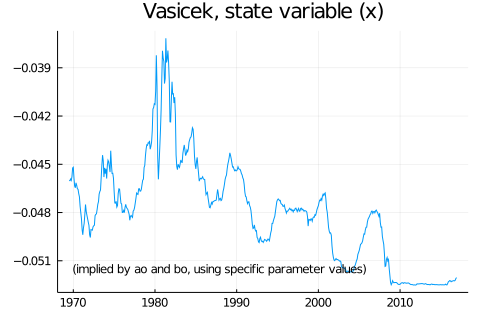

In [7]:
xTicksLoc = Date(1970):Dates.Year(10):Date(2010)
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN,xt,
           legend = false,
           xticks = (xTicksLoc,xTicksLab),
           title = "Vasicek, state variable (x)",
           annotation = (Date(1970),-0.0515,
                         text("(implied by ao and bo, using specific parameter values)",8,:left)) )
display(p1)

## The Likelihood Function

To calculate the log-likelihood, the `VasicekTsCsLLFn` involves the following:

1. Scale the parameters and call on the function `VasicekABFn`.

2. Define 1-step ahead forecast errors of $y_{ot}$ as
$
v_{t}=y_{ot}-\text{E}_{t-1}y_{ot}
$
and its variance as $S=b_{o}^{\prime}\sigma^{2}b_{o}$.

3. Record the contribution to the time series likelihood function in $t$:  the key term is $v_{t}^{\prime}S^{-1}v_{t}$.

4. Define the cross-sectional errors (for $y_{ut}$) as
$
u_{t}=y_{ut}-\hat{y}_{ut} \: \text{, where } \: \hat{y}_{ut}=a_{u}+b_{u}^{\prime}x_{t},
$.

5. Record the contribution to the cross-sectional likelihood function: the key term is $u_{t}^{\prime}\Omega^{-1}
u_{t}$, where the code assumes that $\Omega$ is diagonal,
$
\Omega=I\omega^{2},
$
where $\omega$ is one of the parameters estimated.

6. Sum up the time-series and cross-sectional contributions to the log likelihood function.

In [8]:
function VasicekTsCsLLFn(par,yo,yu,nMo,nMu)
#VasicekTsCsLLFn    Log-likelihood function for estimating the Vasicek model using both
#                   time series and cross sectional information

  J = length(nMu)
  T = size(yo,1)
  if length(nMo) != 1
    error("yo must be a single yield")
  end
                             #re-scale the parameters to 'natural' (monthly) units
  (lambda,mu,p,s2,omega_i) = (par[1]*100,par[2]/1200,par[3],(par[4]/1200)^2,par[5]/1200)

  (ao,bo,xt,au,bu,yuHat) = VasicekABFn(lambda,mu,p,sqrt(s2),nMo,nMu,yo)

  Et1xt    = (1-p)*mu .+ p*[NaN;xt[1:end-1]]   #E(t-1)x(t)
  Et1xt[1] = mu
  Et1yo    = ao .+ Et1xt*bo             #E(t-1)yo(t)
  v        = yo - Et1yo                 #Tx1, forecast error of yo
  S        = bo's2*bo                   #variance of forecast error of yo
  S_1      = inv(S)

  LLo_t = fill(-0.5*log(2*pi) - 0.5*log(det(S)),T)   #constant part
  for t = 1:T
    LLo_t[t] = LLo_t[t] - 0.5*v[t,:]'S_1*v[t,:]      #add time-varying part    
  end

  u        = yu - yuHat                  #TxL, fitted errors of yu
  Omega    = I(J)*omega_i^2
  Omega_1  = inv(Omega)                  #covariance matrix of u

  LLu_t = fill(-0.5*J*log(2*pi) - 0.5*log(det(Omega)),T)
  for t = 1:T  
    LLu_t[t] = LLu_t[t] - 0.5*u[t,:]'Omega_1*u[t,:]
  end

  LL_t    = LLo_t + LLu_t                #Tx1, log likelihood(t), sum of TS and CS
  LL_t[1] = 0.0                          #effectively skip the first observation
  LL      = sum(LL_t)

  return LL, LL_t, yuHat, u, xt

end

VasicekTsCsLLFn (generic function with 1 method)

In [9]:
println("The input parameters are scaled. The input vector contains:")
printmat(["λ/100","μ*1200","ρ","σ*1200","ω*1200"])
par0 = [-2.3,0,0.9,0.5,0.8]                       #starting guess

LL = VasicekTsCsLLFn(par0,yo,yu,nMo,nMu)[1]
printlnPs("The log-likelihood function value at the starting guess: ",LL)

The input parameters are scaled. The input vector contains:
     λ/100
    μ*1200
         ρ
    σ*1200
    ω*1200

The log-likelihood function value at the starting guess: -150184.569


## Minimizing the Loss Function

In [10]:
lower = [-Inf,-Inf,0.0,0.0,0.0]       #lower and upper bounds on the estimates
upper = [Inf,Inf,1.0,100.0,100.0]

Sol  = optimize(par->-VasicekTsCsLLFn(par,yo,yu,nMo,nMu)[1],lower,upper,par0)     #minimize -LL
par1 = Optim.minimizer(Sol)

#re-scale back to monthly model parameters 
(lambda,mu,rho,sigma,omega) = (par1[1]*100,par1[2]/1200,par1[3],par1[4]/1200,par1[5]/1200)
par1b = [lambda,mu,rho,sigma,omega]

println("Estimates:")
xx = [par0 par1 par1b]
printmat(xx,colNames=["start","estimate","monthly scale"],rowNames=["λ","μ","ρ","σ","ω"],width=17)

Estimates:
             start         estimate    monthly scale
λ           -2.300           -2.474         -247.448
μ            0.000            9.270            0.008
ρ            0.900            0.994            0.994
σ            0.500            0.502            0.000
ω            0.800            0.779            0.001



In [11]:
(LL,LL_t,yuHat,u,xt) = VasicekTsCsLLFn(par1,yo,yu,nMo,nMu)

println("The log-likelihood function value at the point estimate: ",LL)

yhatTsCs = [yo yuHat]                      #fitted yields

                                            #average yield curve
(ao,bo,xt,au,bu,yuHatAvg) = VasicekABFn(lambda,mu,rho,sigma^2,nMo,nMu,mean(yo))
yuHatAvg = [mean(yo) yuHatAvg];             #also yo

The log-likelihood function value at the point estimate: 23860.919153723444


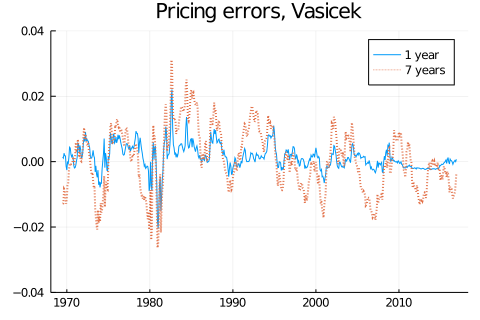

In [12]:
yy = y[:,[3,6]] - yhatTsCs[:,[3,6]]

p1 = plot( dN,12*yy,
           linestyle = [:solid :dot],
           linewidth = [1 2],
           label = ["1 year" "7 years"],
           ylims = (-0.04,0.04),
           xticks = (xTicksLoc,xTicksLab),
           title = "Pricing errors, Vasicek" )
display(p1)

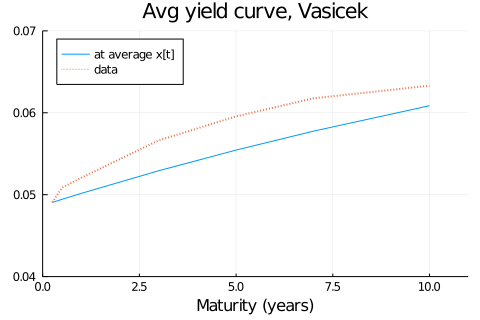

In [13]:
p1 = plot( vec(m),[vec(yuHatAvg) vec(mean(y,dims=1))]*12,
           linestyle = [:solid :dot],
           linewidth = [1 2],
           label = ["at average x[t]" "data"],
           xlims = (0,11),
           ylims = (0.04,0.07),
           legend = :topleft,
           title = "Avg yield curve, Vasicek",
           xlabel = "Maturity (years)" )
display(p1)

## Comparing Vasicek Results to OLS 

by regressing all yields on just the short yield.

To do that we use the function `VasicekNormalize()` to normalize the Vasicek model

$
y_{nt}=a_{n}+b_{n} x_{t}
$

so that the short rate $y_{ot}$ becomes the state variable. This is done by noticing that 

$
y_{ot}=a_{o}+b_{o} x_{t},
$

so 

$
y_{nt}=a_{n} -  a_0 b_n /b_0 + b_{n}/b_o y_{ot}.
$

This last expression can be directly compared to an OLS regression 

$
y_{nt}= \alpha_{n} + \beta_{n}y_{ot} + u_t.
$

In [14]:
function VasicekNormalize(ao,bo,an,bn) #rescaling Vasicek au and bu so
    αn = an - bn/bo*ao
    βn = bn/bo
    return αn,βn
end


bOls = [ones(T) y[:,1]]\y                 #LS of yields on short yield
alfa = bOls[1:1,:]
beta = bOls[2:2,:]

(anN,bnN) = VasicekNormalize(ao,bo,au,bu);   #normalized Vasicek coeffs

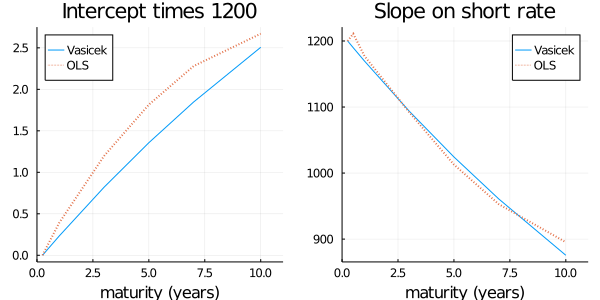

In [15]:
p1 = plot( vec(m),[vec([0 anN]) vec(alfa)]*1200,
           linestyle = [:solid :dot],
           linewidth = [1 2],
           label = ["Vasicek" "OLS"],
           xlims = (0,maximum(m)+1),
           legend = :topleft,
           title = "Intercept times 1200",
           xlabel = "maturity (years)" )

p2 = plot( vec(m),[vec([1 bnN]) vec(beta)]*1200,
           linestyle = [:solid :dot],
           linewidth = [1 2],
           label = ["Vasicek" "OLS"],
           xlims = (0,maximum(m)+1),
           legend = :topright,
           title = "Slope on short rate",
           xlabel = "maturity (years)" )

p = plot(p1,p2,layout=(1,2),size=(600,300))
display(p)